# Archive data
The Wellcome archive sits in a collections management system called CALM, which follows a rough set of standards and guidelines for storing archival records called [ISAD(G)](https://en.wikipedia.org/wiki/ISAD(G). The archive is comprised of _collections_, each of which has a hierarchical set of series, sections, subjects, items and pieces sitting underneath it.  
In the following notebooks I'm going to explore it and try to make as much sense of it as I can programatically.

Let's start by loading in a few useful packages and defining some nice utils.

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.rcParams['figure.figsize'] = (20, 20)

import itertools

import pandas as pd
import numpy as np
import networkx as nx

from sklearn.cluster import AgglomerativeClustering

from umap import UMAP
from tqdm import tqdm_notebook as tqdm

In [17]:
def flatten(input_list):
    return [item 
            for sublist in input_list 
            for item in sublist]

def clean(subject):
    return subject.strip().lower().replace('<p>', '')

let's load up our CALM data. The data has been exported in its entirety as a single `.json`  where each line is a record.  
You can download the data yourself using [this script](https://github.com/wellcometrust/platform/blob/master/misc/download_oai_harvest.py). Stick the `.json` in the neighbouring `/data` directory to run the rest of the notebook.

In [18]:
df = pd.read_json('data/calm_records.json')

In [19]:
len(df)

269111

In [20]:
df.astype(str).describe()

,AccNo,AccessCategory,AccessCategoryNote,AccessConditions,AccessStatus,AccessionNumber,Accruals,Acquisition,AdminHistory,AltRefNo,...,UserWrapped2,UserWrapped3,UserWrapped4,UserWrapped5,UserWrapped6,UserWrapped7,UserWrapped8,UserWrapped9,VehicleDetails,Wheels
count,269111,269111,269111,269111,269111,269111,269111,269111,269111,269111,...,269111,269111,269111,269111,269111,269111,269111,269111,269111,269111
unique,5741,6,433,5760,23,22,99,3370,5939,269052,...,186,26,282,1904,8918,4481,16,231,204,205
top,nan,nan,nan,['The papers are available subject to the usua...,['Open'],nan,nan,nan,nan,nan,...,nan,['Compiled in compliance with General Internat...,nan,nan,nan,nan,nan,nan,nan,nan
freq,256844,268627,268426,143955,209067,269089,268989,251810,261030,42,...,268580,198479,201667,88307,247340,249335,269089,268860,268907,268907


### Exploring individual columns
At the moment I have no idea what kind of information CALM contains - let's look at the list of column names

In [21]:
list(df)

['AccNo',
 'AccessCategory',
 'AccessCategoryNote',
 'AccessConditions',
 'AccessStatus',
 'AccessionNumber',
 'Accruals',
 'Acquisition',
 'AdminHistory',
 'AltRefNo',
 'Appraisal',
 'ArchNote',
 'Arrangement',
 'Author',
 'Bnumber',
 'CatalogueStatus',
 'ClosedUntil',
 'Colour',
 'Comments',
 'Condition',
 'ConditionNote',
 'ConservationPriority',
 'ConservationStatus',
 'Cooling',
 'Copies',
 'Copyright',
 'CorporateKey',
 'Council',
 'CountryCode',
 'Created',
 'Creator',
 'CreatorName',
 'Credits',
 'CurrentOwner',
 'CustodialHistory',
 'Date',
 'Description',
 'Digitised',
 'Document',
 'EHFDEdition',
 'EHFDPublisher',
 'EHFDRevisionDesc',
 'EHPDLanguage',
 'Edition',
 'Engine',
 'EventCode',
 'ExitNote',
 'Extent',
 'FamilyKey',
 'FindingAids',
 'Format',
 'FuelSystem',
 'Hazard',
 'HazardsNote',
 'IssRecvd',
 'Language',
 'Level',
 'Link',
 'LinkedText',
 'LinkedType',
 'LinkedUrl',
 'Location',
 'Material',
 'MgtGroup',
 'Modified',
 'Modifier',
 'Notes',
 'Originals',
 'Origi

Here I'm looking through a sample of values in each column, choosing the columns to explore based on their headings, a bit of contextual info from colleagues and the `df.describe()` above. 

In [22]:
df['Subject']

0                                                       NaN
1                                                       NaN
2                                                       NaN
3                                                       NaN
4                                                       NaN
5                                                       NaN
6                                                       NaN
7                                                       NaN
8                                                       NaN
9                                                       NaN
10                                                      NaN
11                                                      NaN
12             [Disease, Heart, Heart Diseases, Cardiology]
13                                                      NaN
14                                                      NaN
15                                                      NaN
16                                      

### After much trial and error...
Subjects look like an interesting avenue to explore further. Where subjects have _actually_ been filled in and the entry is not `None`, a list of subjects is returned.  
We can explore some of these subjects' subtleties by creating an adjacency matrix. We'll count the number of times each subject appears alongside every other subject and return a big $n \times n$ matrix, where $n$ is the total number of unique subjects.  
We can use this adjacency matrix for all sorts of stuff, but we have to build it first. To start, lets get a unique list of all subjects. This involves unpacking each sub-list and flattening them out into one long list, before finding the unique elements. We'll also use the `clean` function defined above to get rid of any irregularities which might become annoying later on.

In [23]:
dirty_subjects = flatten(df['Subject'].dropna().tolist())
subjects = list(set(map(clean, dirty_subjects)))

At this point it's often helpful to index our data. We'll create two dictionaries which map back and forth between the subjects and their corresponding indicies in the adjacency matrix:

In [24]:
index_to_subject = {index: subject for index, subject in enumerate(subjects)}
subject_to_index = {subject: index for index, subject in enumerate(subjects)}

Lets instantiate an empty numpy array which we'll then fill with our coocurrence data. Each column and each row will represent a subject - each cell (the intersection of a column and row) will therefore represent the 'strength' of the interaction between those subjects. As we haven't seen any interactions yet, we'll set every array element to 0.

In [25]:
adjacency = np.empty((len(subjects), len(subjects)), 
                     dtype=np.uint16)

To populate the matrix, we want to find every possible combination of subject pairs in each sublist from our original column. For example, if we had the subjects

`[Disease, Heart, Heart Diseases, Cardiology]`

we would want to return 

`
[['Disease', 'Disease'],
 ['Heart', 'Disease'],
 ['Heart Diseases', 'Disease'],
 ['Cardiology', 'Disease'],
 ['Disease', 'Heart'],
 ['Heart', 'Heart'],
 ['Heart Diseases', 'Heart'],
 ['Cardiology', 'Heart'],
 ['Disease', 'Heart Diseases'],
 ['Heart', 'Heart Diseases'],
 ['Heart Diseases', 'Heart Diseases'],
 ['Cardiology', 'Heart Diseases'],
 ['Disease', 'Cardiology'],
 ['Heart', 'Cardiology'],
 ['Heart Diseases', 'Cardiology'],
 ['Cardiology', 'Cardiology']]
`

`itertools.product()` will do that for us. We then find the appropriate intersections in the matrix and add another unit of 'strength' to it.  
We'll do this for every row of subjects in the `['Subjects']` column, being careful to exclude any duplicate subjects from our rows after they've been cleaned.

In [26]:
for row_of_subjects in tqdm(df['Subject'].dropna()):
    
    clean_row = list(set([clean(subject) for subject in row_of_subjects]))
    
    for subject_1, subject_2 in itertools.product(clean_row, repeat=2):
        index_1 = subject_to_index[subject_1]
        index_2 = subject_to_index[subject_2]

        adjacency[index_1, index_2] += 1

HBox(children=(IntProgress(value=0, max=16664), HTML(value='')))

We can do all sorts of fun stuff now - adjacency matrices are the foundation on which all of graph theory is built. However, because it's a bit more interesting, I'm going to start with some dimensionality reduction. We'll get to the graphy stuff later.  
Using [UMAP](https://github.com/lmcinnes/umap), we can squash the $n \times n$ dimensional matrix down into a $n \times m$ dimensional one, where $m$ is some arbitrary integer. Setting $m$ to 2 will then allow us to plot each subject as a point on a two dimensional plane. UMAP will try to preserve the 'distances' between subjects - in this case, that means that related or topically similar subjects will end up clustered together, and different subjects will move apart.

In [27]:
embedding_2d = pd.DataFrame(UMAP(n_components=2)
                            .fit_transform(adjacency))

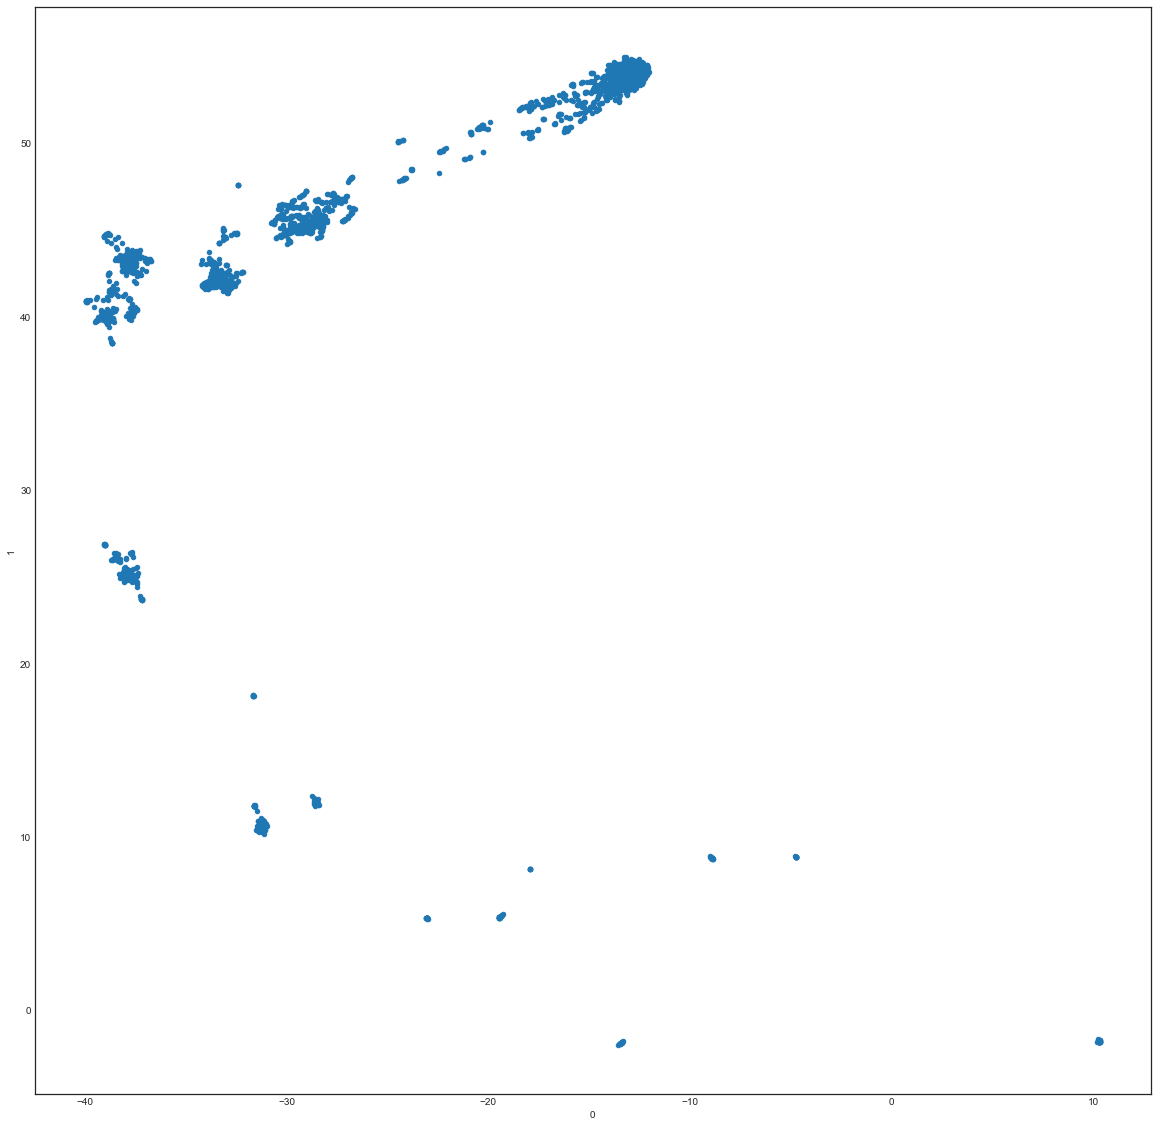

In [28]:
embedding_2d.plot.scatter(x=0, y=1);

We can isolate the clusters we've found above using a number of different methods - `scikit-learn` provides easy access to some very powerful algorithms. Here I'll use a technique called _agglomerative clustering_, and make a guess that 15 is an appropriate number of clusters to look for. The guess is based on my own intuition and experience with the kind of dataset we're working with, past experience with this particular clustering algorithm, and the way that the data is distributed under UMAP in the previous cell. In other contexts one might choose 5, 30, 200...

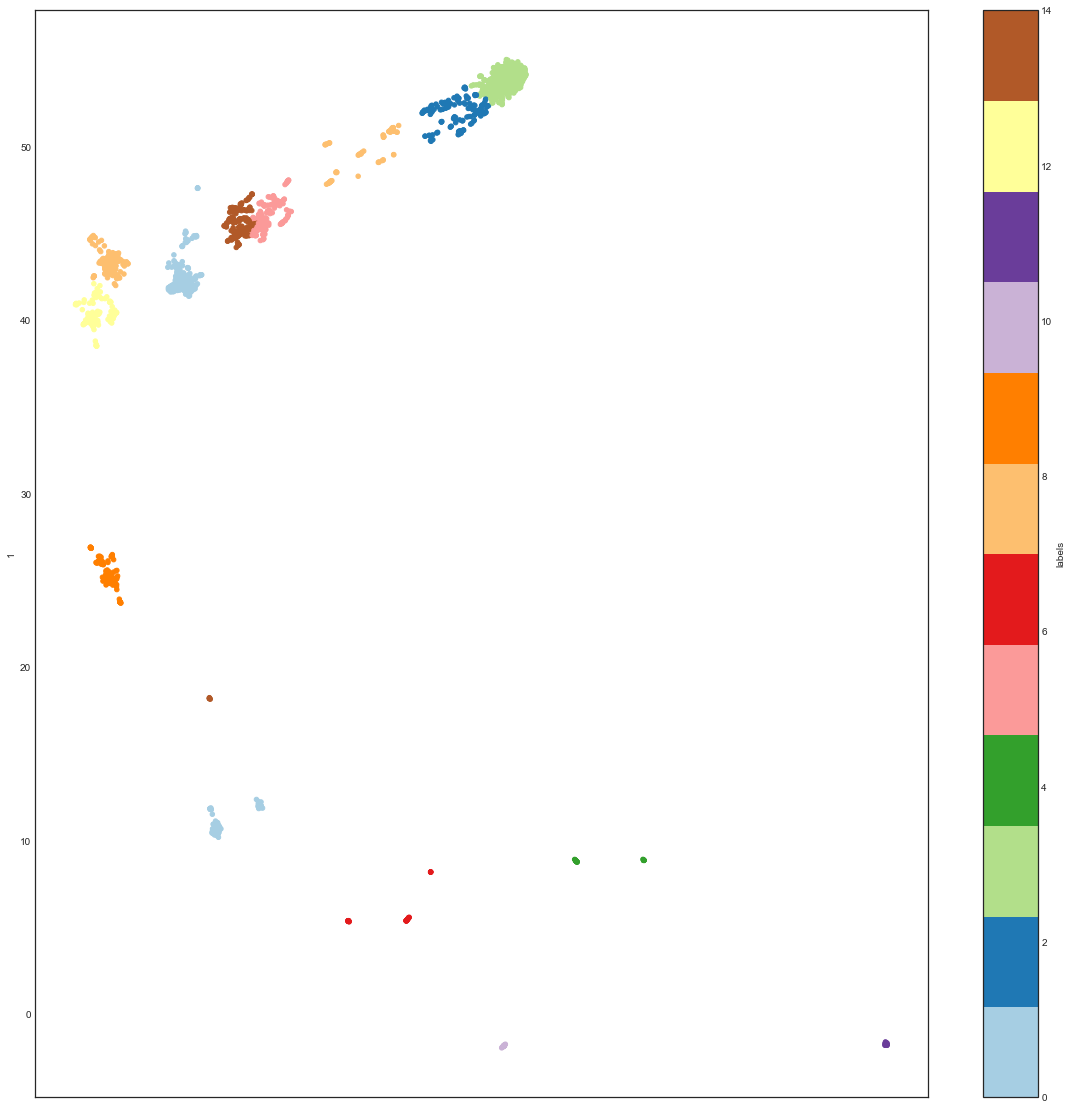

In [29]:
n_clusters = 15

embedding_2d['labels'] = (AgglomerativeClustering(n_clusters)
                          .fit_predict(embedding_2d.values))
                          
embedding_2d.plot.scatter(x=0, y=1, 
                          c='labels', 
                          cmap='Paired');

We can now use the `index_to_subject` mapping that we created earlier to examine which subjects have been grouped together into clusters

In [30]:
for i in range(n_clusters):
    print(str(i) + ' ' + '-'*80 + '\n')
    print(np.sort([index_to_subject[index]
                   for index in embedding_2d[embedding_2d['labels'] == i].index.values]))
    print('\n')

0 --------------------------------------------------------------------------------

['abortion, induced' 'accidents' 'acids' 'advertising' 'alcoholism'
 'allergy and immunology' 'ambergris' 'analgesics' 'anesthesia' 'aneurysm'
 'animals' 'aortic valve stenosis' 'appendicitis' 'arsphenamine' 'aspirin'
 'asthma' 'autopsy' 'barbiturates' 'beer' 'biscuits' 'brassica' 'bread'
 'butter' 'cacao' 'cake' 'candy' 'carbohydrates' 'cattle' 'cereals'
 'cerebral arterial disease' 'cheese' 'chemistry, agricultural'
 'christian science' 'cider' 'colitis' 'colouring agents' 'condiments'
 'congenital,hereditary and neonatal disease and abnormalities' 'cooking'
 'cooking (deer)' 'cooking (poultry)' 'cooking (venison)'
 'cucumis sativus' 'dairy products' 'daucus carota' 'death' 'desserts'
 'diabetes mellitus' 'diphtheria' 'dried fruit'
 'drug-related side effects and adverse reactions' 'ecology' 'economics'
 'eggs' 'embolism' 'endocarditis' 'environmental health' 'ether, ethyl'
 'european rabbit' 'ferment

Interesting! Taking a look at some of the smaller clusters of subjects (for the sake of space and your willingness to read lists of 100s of subjects):

One seems to be quite distinctly involved with drugs and associated topics/treatments:
```
['acquired immunodeficiency syndrome' 'alcohol' 'amphetamines'
 'analgesics, opioid' 'campaign' 'cannabis' 'cocaine' 'counseling'
 'counterculture' 'crime' 'drugs' 'education' 'hallucinogens' 'heroin'
 'hypnotics and sedatives' 'information services' 'inhalant abuse'
 'lysergic acid diethylamide' 'n-methyl-3,4-methylenedioxyamphetamine'
 'opioid' 'policy' 'prescription drugs' 'rehabilitation' 'renabilitation'
 'self-help']
```

others are linked to early/fundamental research on DNA and genetics:

```
['bacteriophages' 'biotechnology' 'caenorhabditis elegans'
 'chromosome mapping' 'cloning, organism' 'discoveries in science' 'dna'
 'dna, recombinant' 'genetic code' 'genetic engineering'
 'genetic research' 'genetic therapy' 'genome, human' 'genomics'
 'magnetic resonance spectroscopy' 'meiosis' 'models, molecular'
 'molecular biology' 'nobel prize' 'retroviridae' 'rna'
 'sequence analysis' 'viruses']
```

and others about food
```
['acids' 'advertising' 'ambergris' 'animals' 'beer' 'biscuits' 'brassica'
 'bread' 'butter' 'cacao' 'cake' 'candy' 'carbohydrates' 'cattle'
 'cereals' 'cheese' 'chemistry, agricultural' 'cider' 'colouring agents'
 'condiments' 'cooking (deer)' 'cooking (poultry)' 'cooking (venison)'
 'cucumis sativus' 'dairy products' 'daucus carota' 'desserts'
 'dried fruit' 'ecology' 'economics' 'eggs' 'environmental health'
 'european rabbit' 'fermentation' 'food additives' 'food and beverages'
 'food preservation' 'food, genetically modified' 'fruit' 'fruit drinks'
 'fungi' 'game and game-birds' 'grapes' 'hands' 'health attitudes'
 'herbaria' 'honey' 'jam' 'legislation' 'lettuce' 'meat' 'meat products'
 'nuts' 'oatmeal' 'olive' 'onions' 'peas' 'pickles' 'pies' 'poultry'
 'preserves (jams)' 'puddings' 'rice' 'seafood' 'seeds' 'sheep'
 'sociology' 'solanum tuberosum' 'spinacia oleracea' 'sweetening agents'
 'swine' 'syrups' 'vegetables' 'vitis' 'whiskey' 'wild flowers' 'wine']
```

These are all noticeably different themes, and they appear to be nicely separated in the topic-space we've built.